# Métodos Numéricos II. Práctica 3.

**Autor:** Arturo Olivares Martos
***

- **Asignatura:** Métodos Numéricos II.
- **Curso Académico:** 2024-25.
- **Grado:** Doble Grado en Ingeniería Informática y Matemáticas.
- **Grupo:** Único.
- **Profesor:** Juan Antonio Villegas Recio
- **Descripción:** Práctica 3 de la asignatura Métodos Numéricos II.
<!--- **Fecha:** 17 de abril de 2023. -->
<!-- - **Duración:** -->

En primer lugar, importamos las librerías necesarias para la práctica.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['text.usetex'] = True

## Ejercicio 1


> **Ejercicio 1:** Repita las aproximaciones anteriores con diferentes valores de $N$ (y por tanto de $h$) y compruebe el efecto en cuanto a mayor o menor precisión, estabilidad y coste computacional.


Definimos en primer lugar, para cada método de Euler, una función que calcula un paso. De esta forma, podremos luego generalizar el proceso.

In [2]:
def euler_explicito_paso(f, t_n, x_n, h):
    """
    Realiza un paso del método de Euler explícito.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """

    return x_n + h * f(t_n, x_n)

In [3]:
from scipy.optimize import fsolve
def euler_implicito_paso(f, t_n, x_n, h):
    """
    Realiza un paso del método de Euler implícito.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """

    # Definimos la función que queremos resolver
    eq = lambda x: x_n + h * f(t_n + h, x) -x   # -x porque se necesita que esté igualado a 0
    # Usamos fsolve para encontrar la raíz de la ecuación
    return fsolve(eq, x_n)[0]

Ahora, definimos la función genérica que emplea un método de discretización de $k$ pasos, para luego particularizarla si $k=1$.

In [4]:
def metodo_k_pasos(f,a,b,x,N,metodo):
    """
    Resuelve la ecuación diferencial usando el método de len(x) pasos proporcionado.

    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        a (float): Valor inicial de la variable independiente.
        b (float): Valor final de la variable independiente.
        x (array_like): Valores iniciales de la variable dependiente. x[i]= x(a + i * h).
        N (int): Número de pasos.
        metodo (function): Método de K paso empleado. Debe aceptar los argumentos (f, t_n, x, h).
    Returns:
        tuple: Dos listas, una con los valores de la variable independiente y otra con los valores de la variable dependiente.
    """
    h = (b - a) / N  # Tamaño del paso
    k = len(x)  # Número de pasos que se utilizarán para el método

    t_values = np.linspace(a, b, N + 1)  # Valores de la variable independiente
    x_values = np.zeros(N + 1)  # Inicializamos los valores de la variable dependiente

    for i in range(k):
        x_values[i] = x[i]


    
    for n in range(N-k+1):
        if (k==1):
            x_ant = x_values[n]
        else:
            x_ant = x_values[n:n + k]
        
        x_values[n + k] = metodo(f, t_values[n], x_ant, h)

    return t_values, x_values

In [5]:
def metodo_un_paso(f, a,b,mu, N, metodo):
    """
    Resuelve la ecuación diferencial usando el método de un paso proporcionado.

    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        a (float): Valor inicial de la variable independiente.
        b (float): Valor final de la variable independiente.
        mu (float): Valor inicial de la variable dependiente.
        N (int): Número de pasos.
        metodo (function): Método de un paso empleado. Debe aceptar los argumentos (f, t_n, x_n, h).
    Returns:
        tuple: Dos listas, una con los valores de la variable independiente y otra con los valores de la variable dependiente.
    """
    return metodo_k_pasos(f, a, b, [mu], N, metodo)

Implementamos además la siguiente función que, dado un PVI, calcula su solución simbólicamente.

In [6]:
def resolver_pvi_simbolico(f_numeric, t0, x0):
    """
    Resuelve un problema de valor inicial (PVI) simbólicamente usando SymPy.

    Args:
        f_numeric (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, y).
        t0 (float): Valor inicial de la variable independiente.
        yx0 (float): Valor inicial de la variable dependiente.
    Returns:
        sympy expression: Expresión simbólica que representa la solución del PVI.
    """
    # Variables simbólicas
    t = sp.symbols('t')
    x = sp.Function('x')

    # Convertir f_numeric en f_sympy(t, x)
    x_sym = x(t)
    f_sympy = f_numeric(t, x_sym)

    # EDO simbólica: x' = f(t, x)
    edo = x(t).diff(t)-f_numeric(t, x_sym)
    sp.Eq(edo,0)

    # Resolver con condición inicial
    sol = sp.dsolve(edo, x(t), ics={x(t0): x0})

    # Extraer el lado derecho: x(t) = ...
    x_exacta = sol.rhs

    return x_exacta

Una vez realizado esto, realizamos la comparativa de los métodos de Euler con diferentes valores de $N$ . El PVI que emplearemos será el siguiente, que sabemos que tiene como solución exacta $x(t) = e^t$:
$$
\left\{\begin{array}{rcl}
x'(t) &=& x(t) \\
x(0) &=& 1
\end{array}\right.
$$

In [7]:
def f(t, x):
    """
    Define la ecuación diferencial a resolver.
    
    Args:
        t (float): Valor de la variable independiente.
        x (float): Valor de la variable dependiente.
    Returns:
        float: Valor de la derivada de x respecto a t.
    """
    return x

display(resolver_pvi_simbolico(f, 0, 1))

exp(t)

Construimos además una función que nos permite, dado el nombre de un método, obtener un string que lo identifique.

In [8]:
def obtener_nombre(metodo):
    """
    Obtiene el nombre del método de un paso.
    
    Args:
        metodo (function): Método de un paso empleado.
    Returns:
        str: Nombre del método.
    """

    nombre = metodo.__name__ 
    # Si termina en "paso", lo eliminamos
    if nombre.endswith('_paso'):
        nombre = nombre[:-len('_paso')]
    # Reemplazamos los guiones bajos por espacios
    nombre = nombre.replace('_', ' ')
    # Ponemos en mayuscula cada palabra
    nombre = nombre.title()

    # Si hay que poner tildes, se ponen
    nombre = nombre.replace('Explicito', 'Explícito')
    nombre = nombre.replace('Implicito', 'Implícito')
    
    return nombre

In [9]:
import matplotlib.cm as cm
import itertools

def comparativa(f, a, b, x, metodos, Nmin=2, Nmax=16, razonN=2, title=None):
    """
    Compara diferentes métodos de un paso para resolver una EDO.
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        a (float): Valor inicial de la variable independiente.
        b (float): Valor final de la variable independiente.
        x (vector): Valores iniciales de la variable dependiente.
        metodos (list): Lista de métodos de un paso a comparar.
        Nmin (int): Número mínimo de pasos.
        Nmax (int): Número máximo de pasos.
        razonN (int): Cada vez, se multiplica por este valor el número de pasos.
        title (str, optional): Título del gráfico. Si no se proporciona, se generará uno por defecto.
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x(t)$")

    if isinstance(x, (int, float)):
        x = [x]

    N_values = list([Nmin * (razonN ** i) for i in range(int(np.log(Nmax / Nmin) / np.log(razonN)) + 1)])

    t = sp.symbols('t')


    # Intenta resolver el PVI simbólicamente
    hay_sol_exacta = None
    try:
        x_exact_sym = resolver_pvi_simbolico(f, a, x[0])
        x_exacta_np = sp.lambdify(t, x_exact_sym, 'numpy')
        hay_sol_exacta = True
    except Exception as e:
        print(f"No se pudo resolver el PVI simbólicamente.")
        hay_sol_exacta = False
        


    all_markers = [
        m for m in plt.Line2D.markers
        if isinstance(m, str) and m not in (' ', '', None) and m != 'None'
    ]


    # Crear iterador cíclico de marcadores
    marcador_iter = itertools.cycle(all_markers[:len(N_values)])

    # Asociar un marcador fijo a cada N
    N_a_marcador = {N: next(marcador_iter) for N in N_values}
    colormap = plt.colormaps.get_cmap('Set1').resampled(len(metodos))


    bloques_errores = []
    for i, N in enumerate(N_values):
        marcador = N_a_marcador[N]
        for j, metodo in enumerate(metodos):
            color = colormap(j)
            

            t_values, x_values = metodo_k_pasos(f, a, b, x, N, metodo)
            
            label = f"{obtener_nombre(metodo)} ($N={N}$)"
            ax.plot(t_values, x_values, marker=marcador, color=color, linestyle='-', label=label)

            if (hay_sol_exacta):
                # Calculamos el ECM y MEA
                ECM = ((x_values - x_exacta_np(t_values))**2).mean()
                MEA = np.max(np.abs(x_values - x_exacta_np(t_values)))

                # Posición en la cuadrícula de texto (i: columna, j: fila)
                dx = 0.3  # separación horizontal
                dy = 0.2  # separación vertical
                x_text = 1.02 + i * dx
                y_text = 0.7+ (0.05*len(metodos)) - j * dy

                # Mostrar texto encima de la leyenda, a la derecha del gráfico
                texto = f"{obtener_nombre(metodo)} ($N={N}$):\n\t- MEA={MEA:.4e}\n\t- ECM={ECM:.4e}"
                bloques_errores.append((i, j, texto, color))


    if (hay_sol_exacta):
        t_exact = np.linspace(a, b, 100)
        x_exact = x_exacta_np(t_exact)
        ax.plot(t_exact, x_exact,
                label=r"Solución exacta: $x(t)=" + sp.latex(x_exact_sym) + r"$",
                color='black')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    plt.subplots_adjust(bottom=0.2, right=0.75)  # deja espacio abajo y a la derecha

    if (hay_sol_exacta):
        for i, (col, fila, texto, color) in enumerate(bloques_errores):
            # Espaciado vertical y horizontal según columna y fila
            x_text = 0.05 + col * 0.3
            y_text = 0.05 - fila * 0.11
            fig.text(x_text, y_text, texto,
                    fontsize=9, color='black',
                    bbox=dict(facecolor=color, alpha=0.6, edgecolor='none'))

    plt.show()


Comprobemos su uso con el PVI anterior:

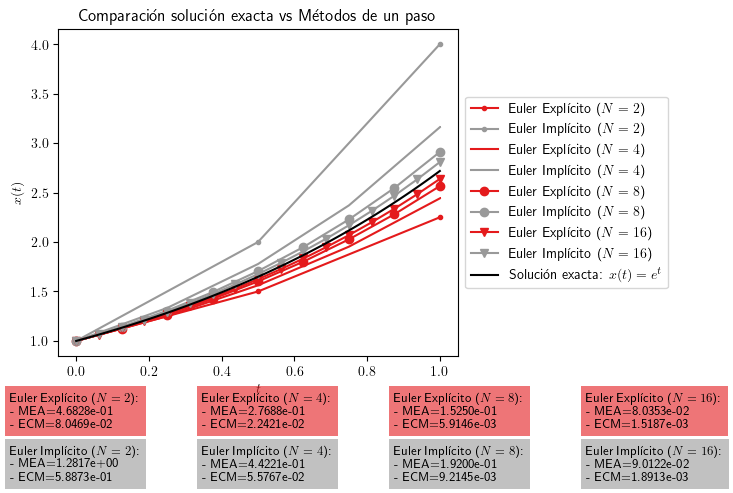

In [10]:
comparativa(f, 0, 1, 1, [euler_explicito_paso, euler_implicito_paso], title="Comparación solución exacta vs Métodos de un paso")

Como vemos, ambos dan resultados similares.

## Ejercicio 2

> **Ejercicio 2 ✅:** A partir de la implementación del algoritmo del método de Euler explícito, realice las modificaciones oportunas para obtener también las implementaciones correspondientes a los métodos de Euler mejorado (o del punto medio), así como del de Euler modificado (o de Heun).

Debido a cómo se ha implementado en el apartado anterior, este proceso es directo. Tan solo debemos definir las funciones correspondientes a cada uno de los métodos de Euler mejorado y modificado para un único paso.

In [11]:
def euler_mejorado_paso(f, t_n, x_n, h):
    """
    Realiza un paso del método de Euler Mejorado (o del punto medio).
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """

    return x_n + h * f(t_n + h/2, x_n + h/2 * f(t_n, x_n))

def euler_heun_paso(f, t_n, x_n, h):
    """
    Realiza un paso del método de Heun (o Euler modificado).
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """

    k1 = f(t_n, x_n)
    k2 = f(t_n + h, x_n + h * k1)
    
    return x_n + h/2 * (k1 + k2)

Realizamos ahora la comparativa con los 4 métodos de Euler, empleando el mismo PVI que en el apartado anterior. Como podemos ver, estos métodos son mucho más precisos que los dos anteriores. De hecho, para un número de pasos muy bajo, es difícil apreciar la diferencia entre ellos.

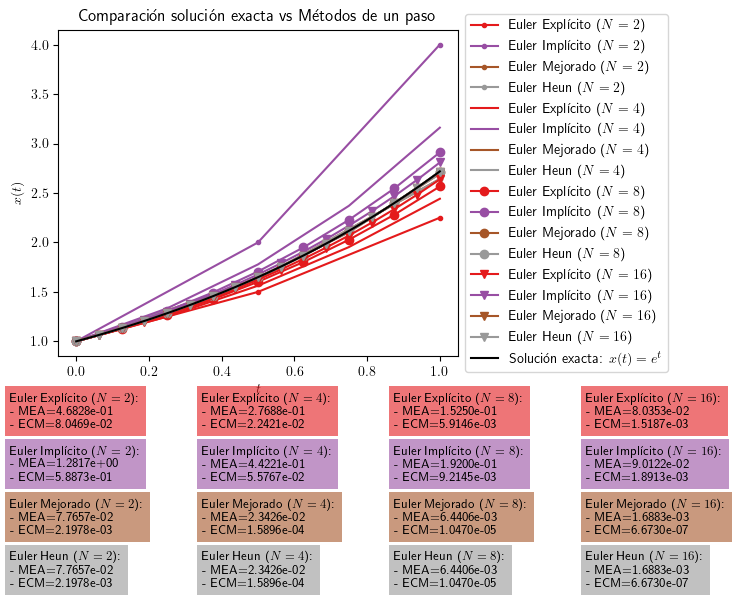

In [12]:
comparativa(f, 0, 1, 1, [euler_explicito_paso, euler_implicito_paso, euler_mejorado_paso, euler_heun_paso], Nmin=2, Nmax=16, razonN=2, title="Comparación solución exacta vs Métodos de un paso")

## Ejercicio 4

> **Ejercicio  4 ✅:** Programe el método de Runge-Kutta de 4 evaluaciones y grafique la sucesión de aproximaciones y calcule el error cuadrático medio y el máximo error absoluto con respecto a la solución exacta.


Programamos en primer lugar el método de Runge-Kutta de $m$ evaluaciones general.

In [13]:
def runge_kutta_m_paso_explícito(f, t_n, x_n, h, A, B, C):
    """
    Realiza un paso del método de Runge-Kutta de orden m.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
        A (list): Coeficientes A del método Runge-Kutta.
        B (list): Coeficientes B del método Runge-Kutta.
        C (list): Coeficientes C del método Runge-Kutta.

        El arreglo de Butcher será:
         C | A
            ---
            B
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """

    # Comprobamos que B y C tienen la misma longitud
    if len(B) != len(C):
        raise ValueError("B y C deben tener la misma longitud.")
    # Comprobamos que A es una matriz cuadrada de tamaño len(B)
    if len(A) != len(B) or any(len(row) != len(B) for row in A):
        raise ValueError("A debe ser una matriz cuadrada del mismo tamaño que B.")
    # Comprobamos que A es triangular inferior
    for i in range(len(A)):
        for j in range(i, len(A)):
            if A[i][j] != 0:
                raise ValueError("A debe ser una matriz triangular inferior con diagonal cero.")
    
    K = np.zeros(len(B))  # Inicializamos el vector de K_i
    for i in range(len(B)):
        K[i] = f(t_n + C[i] * h, x_n + h * sum(A[i][j] * K[j] for j in range(i)))
    
    return x_n + h * sum(B[i] * K[i] for i in range(len(B)))


Programamos ahora el método de Runge-Kutta de 4 evaluaciones, sabiendo que su arreglo de Butcher es el siguiente:
$$
\begin{array}{c|cccc}
0 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{2} & 0 & \frac{1}{2} & 0 & 0 \\
1 & 0 & 0 & 1 & 0 \\
\hline
& \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
\end{array}
$$

In [14]:
def runge_kutta_4_paso(f, t_n, x_n, h):
    """
    Realiza un paso del método de Runge-Kutta de orden 4.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """
    A = [
        [0, 0, 0, 0],
        [1/2, 0, 0, 0],
        [0, 1/2, 0, 0],
        [0, 0, 1, 0]
    ]
    B = [1/6, 1/3, 1/3, 1/6]
    C = [0, 1/2, 1/2, 1]

    return runge_kutta_m_paso_explícito(f, t_n, x_n, h, A, B, C)

A continuación, realizamos una función que, dado un método de un paso, grafica la solución exacta, la sucesión de aproximaciones y calcula el error cuadrático medio y el máximo error absoluto con respecto a la solución exacta.

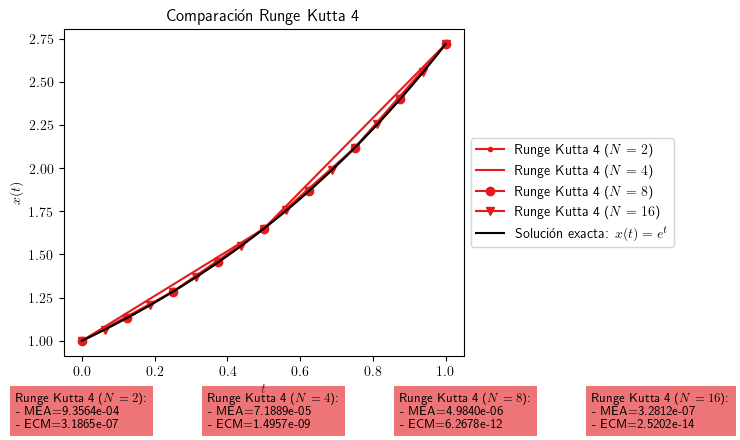

In [15]:
comparativa(f, 0, 1, 1, [runge_kutta_4_paso], Nmin=2, Nmax=16, razonN=2, title="Comparación Runge Kutta 4")

## Ejercicio 5

> **Ejercicio 5 (Ejercicio final de las diapositivas) ✅:** Se pretende aproximar la solución del PVI:
> $$
> \left\{\begin{array}{rcl}
> x'(t) &=& \dfrac{t-x(t)} 2 \\
> x(0) &=& 1
> \end{array}\right..
> $$
> en $[0,3]$
> 1. Usa el método de Runge-Kutta de 2 evaluaciones con $\alpha= 3/4$ y $\beta=2/3$ para $h = 1$, $h = 1/2$, $h = 1/4$ y $h = 1/8$ y compara los resultados obtenidos.
> 2. Repite el apartado anterior usando Runge-Kutta clásico.
> 
> Nota: La solución exacta es $x(t) = 3 e^{-t/2} + t -2$.

In [16]:
def f(t, x):
    """
    Define la ecuación diferencial a resolver.
    
    Args:
        t (float): Valor de la variable independiente.
        x (float): Valor de la variable dependiente.
    Returns:
        float: Valor de la derivada de x respecto a t.
    """
    return 0.5 * (t-x)

In [17]:
def runge_kutta_2_paso(f, t_n, x_n, h, alpha=3/4, beta=2/3):
    """
    Realiza un paso del método de Runge-Kutta de orden 2 con coeficientes alpha y beta.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t_n (float): Valor actual de la variable independiente.
        x_n (float): Valor actual de la variable dependiente.
        h (float): Tamaño del paso.
        alpha (float): Coeficiente alpha del método Runge-Kutta.
        beta (float): Coeficiente beta del método Runge-Kutta.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """
    A = [
        [0, 0],
        [beta, 0]
    ]
    B = [1 - alpha, alpha]
    C = [0, beta]

    return runge_kutta_m_paso_explícito(f, t_n, x_n, h, A, B, C)

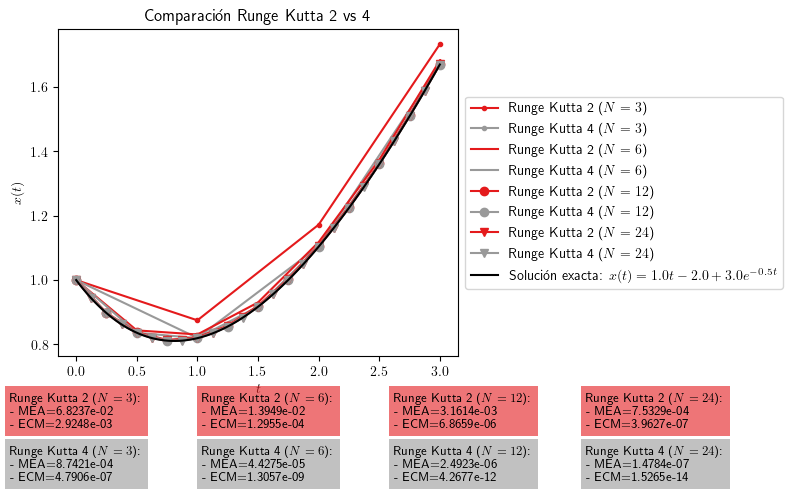

In [18]:
comparativa(f, 0, 3, 1, [runge_kutta_2_paso, runge_kutta_4_paso], Nmin=3, Nmax=24, razonN=2, title="Comparación Runge Kutta 2 vs 4")

## Ejercicio 6

> **Ejercicio 6:** A partir de la implementación del algoritmo del método de Adams-Bashforth anterior, realice las modificaciones oportunas para intentar obtener también las implementaciones correspondientes a otros métodos de tipo Adams (al menos 3), como Adams-Moulton (AM), Milne-Simpson, Nyström y/o Newton-Cotes.

Programamos en primer lugar el método de Adams-Bashforth de $k$ pasos general.

In [19]:
import math
def metodo_ABK_paso(f, t, x, h):
    """
    Método de Adams-Bashforth de k pasos.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t (float): Valor inicial de la variable independiente. t=t_n
        x (array): Valores de la variable dependiente en los k pasos anteriores. x[i]=x_{n-i}
        h (float): Tamaño del paso.
        k (int): Número de pasos del método de Adams-Bashforth.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+k}).
    """
    
    k = len(x)  # Número de pasos anteriores
    if k < 1:
        raise ValueError("El método de Adams-Bashforth requiere al menos un paso anterior.")
    
    # Calculamos los coeficientes de Adams-Bashforth, B[i]. Para ello, resolvemos A*B=C.

    # Matriz C de términos independientes
    C = np.zeros(k)
    for i in range(k):
        p = i+1
        numerador = k**p -(k-1)**p
        denominador = math.factorial(p)
        C[i] = numerador / denominador

    # Matriz A de coeficientes
    A = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            numerador=j**i
            denominador = math.factorial(i)
            A[i][j] = numerador / denominador
    # Resolvemos el sistema A*B=C
    B = np.linalg.solve(A, C)

    res = x[-1] + h * sum(B[i] * f(t+i*h, x[i]) for i in range(k))


    # Calculamos el valor de x_{n+k}
    return res

Lo programamos ahora para el PVI que hemos estado empleando en los ejercicios anteriores, que sabemos que tiene como solución exacta $x(t) = e^t$. 

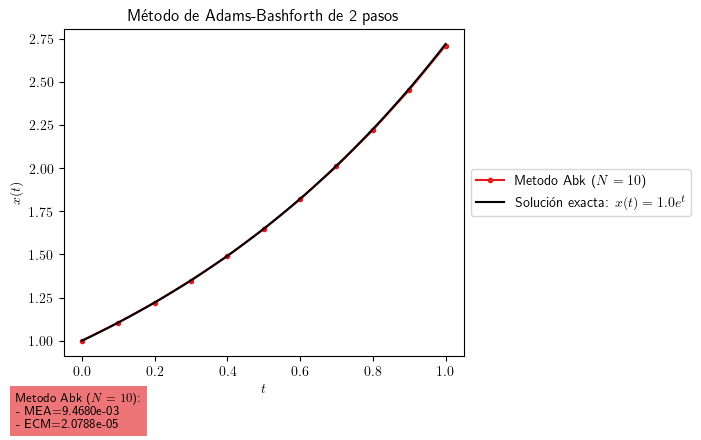

In [20]:
def f(t, x):
    """
    Define la ecuación diferencial a resolver.
    
    Args:
        t (float): Valor de la variable independiente.
        x (float): Valor de la variable dependiente.
    Returns:
        float: Valor de la derivada de x respecto a t.
    """
    return x

sol = lambda t: np.exp(t)
N = 10
k = 2
x = [sol(i*1/N) for i in range(k)]

comparativa(f, 0, 1, x, [metodo_ABK_paso], Nmin=10, Nmax=10, title=f"Método de Adams-Bashforth de {k} pasos")

Programamos en primer lugar el método de Adams-Moulton de $k$ pasos general.

In [21]:
import math
def metodo_AMK_paso(f, t, x, h, ant=None):
    """
    Método de Adams-Moulton de k pasos.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t (float): Valor inicial de la variable independiente. t=t_n
        x (array): Valores de la variable dependiente en los k pasos anteriores. x[i]=x_{n-i}
        h (float): Tamaño del paso.
        k (int): Número de pasos del método de Adams-Moulton.
        ant (float): Si se le pasa un valor, se realiza tan solo una iteración (de cara a corrector)
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+k}).
    """
    
    k = len(x)  # Número de pasos anteriores
    if k < 1:
        raise ValueError("El método de Adams-Bashforth requiere al menos un paso anterior.")
    
    # Calculamos los coeficientes de Adams-Bashforth, B[i]. Para ello, resolvemos A*B=C.

    # Matriz C de términos independientes
    C = np.zeros(k+1)
    for i in range(k+1):
        p = i+1
        numerador = k**p -(k-1)**p
        denominador = math.factorial(p)
        C[i] = numerador / denominador

    # Matriz A de coeficientes
    A = np.zeros((k+1, k+1))
    for i in range(k+1):
        for j in range(k+1):
            numerador=j**i
            denominador = math.factorial(i)
            A[i][j] = numerador / denominador
    # Resolvemos el sistema A*B=C
    B = np.linalg.solve(A, C)


    eq = lambda ans: x[-1] + h * sum(B[i] * f(t+i*h, x[i]) for i in range(k)) + h*B[k] * f(t+k*h, ans) - ans      # Ha de estar = 0


    if (ant != None):
        res = eq(ant) + ant
    else:
        res = fsolve(eq, x[-1])[0]
    
    return res

Realizamos ahora la comparativa de los métodos de Adams-Bashforth y Adams-Moulton con $k=2$y $N=10$. Como podemos ver, el método de Adams-Moulton es más preciso que el de Adams-Bashforth, como era de esperar, ya que el primero es un método implícito y el segundo es explícito.

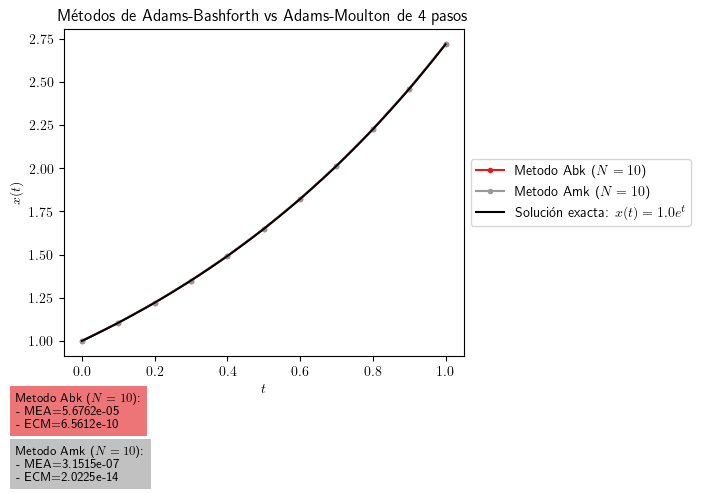

In [22]:
sol = lambda t: np.exp(t)
N = 10
k = 4
x = [sol(i*1/N) for i in range(k)]

comparativa(f, 0, 1, x, [metodo_ABK_paso, metodo_AMK_paso], Nmin=10, Nmax=10, title=f"Métodos de Adams-Bashforth vs Adams-Moulton de {k} pasos")

## Ejercicio 7

> **Ejercicio 7 ✅:** Implemente un método MML Predictor-Corrector combinando un predictor AB de 5 pasos con un corrector AM de 4, y aplicando una sólo corrección en cada iteración:
> $$
> P: \qquad x_{n+5}^{(0)} = x_{n+4} + \frac{h}{720} (1901 f_{n+4} -2774 f_{n+3} +2616 f_{n+2} - 1274 f_{n+1} + 251 f_n)
> $$
> $$
> C^1: \qquad  x_{n+5} = x_{n+4} + \frac{h}{720} (251 f(t_{n+5},x_{n+5}^{(0)}) + 646 f_{n+4} -264 f_{n+3} +106 f_{n+2} - 19 f_{n+1} )
> $$

Creamos la siguinte función genérica. Notemos que `len(x)` representa el número de pasos del predictor, pero el número de pasos del corrector no se puede obtener. Asumimos que siempre el corrector tiene un paso menos.

In [23]:
def predictor_corrector_paso(f, predictor, corrector,m, t,x,h):
    """
    Método predictor-corrector para resolver una EDO.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        predictor (function): Método predictor a utilizar.
        corrector (function): Método corrector a utilizar.
        m (int): Número de correcciones del método predictor-corrector.
        t (float): Valor actual de la variable independiente.
        x (array): Valores de la variable dependiente en los m pasos anteriores. x[i]=x_{n-i}.
        h (float): Tamaño del paso.
    Returns:
        tuple: Dos listas, una con los valores de la variable independiente y otra con los valores de la variable dependiente.
    """
    k= len(x)  # Número de pasos que se utilizarán para el método
    
    
    x_corr = predictor(f, t, x, h)

    for _ in range(m):
        x_corr = corrector(f, t+h, x[1:], h, ant=x_corr)
    


    return x_corr

Para probar el método MML Predictor-Corrector, emplearemos el PVI que hemos estado utilizando en los ejercicios anteriores, que sabemos que tiene como solución exacta $x(t) = e^t$. Lo usaremos con el método de Adams-Bashforth de 5 pasos como predictor y el método de Adams-Moulton de 4 pasos como corrector. Para probarlo con la función `comparar`, debido a su funcionamientos hemos de emplear la siguiente función auxiliar:

In [24]:
def predictor_corrector_AB_AM_5(f,t,x,h):
    """
    Función auxiliar para el predictor-corrector.
    
    Args:
        f (function): Función que define la ecuación diferencial. Debe aceptar dos argumentos (t, x).
        t (float): Valor actual de la variable independiente.
        x (array): Valores de la variable dependiente en los m pasos anteriores. x[i]=x_{n-i}
        h (float): Tamaño del paso.
    Returns:
        float: Valor de la variable dependiente en el siguiente paso (x_{n+1}).
    """
    return predictor_corrector_paso(f, metodo_ABK_paso, metodo_AMK_paso, 1, t, x, h)

Tras la prueba, vemos que se consiguen resultados similares al método de Adams-Moulton de 5 pasos, mientras que aquí no se ha resuelto nignuna ecuación implícita.

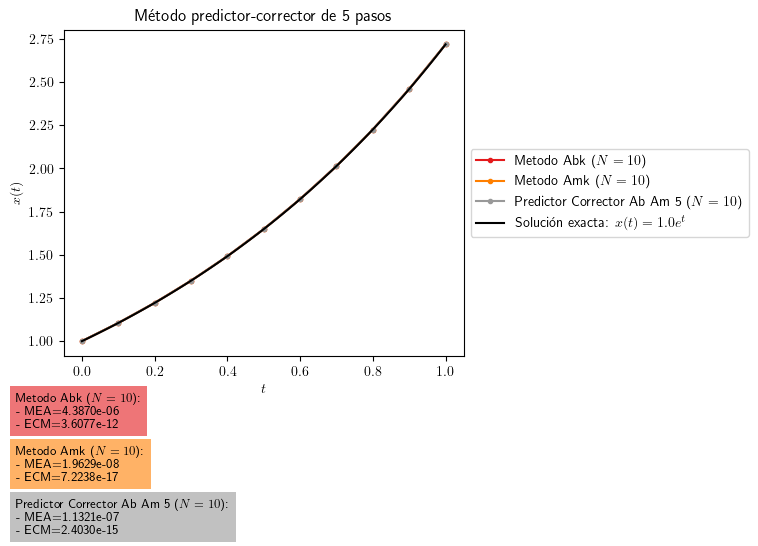

In [25]:
sol = lambda t: np.exp(t)
N = 10
k = 5
x = [sol(i*1/N) for i in range(k)]

comparativa(f, 0, 1, x, [metodo_ABK_paso, metodo_AMK_paso,predictor_corrector_AB_AM_5], Nmin=10, Nmax=10, title=f"Método predictor-corrector de {k} pasos")

## Ejercicio 8

> **Ejercicio 8:** Se considera el sistema de ecuaciones diferenciales
> $$\left\{\begin{array}{rcl}
> x_1' &=& - 4 x_1 + 3 x_2 + 6 \\
> x_2' &=& -2.4 x_1 + 1.6 x_2 + 3.6
> \end{array}\right.
> $$
> con condiciones iniciales $x_1(0) = 0$, $x_2(0) = 0$. Calcula y representa gráficamente la solución del sistema.

In [26]:
from scipy import integrate
def resuelve_sistema(f,a,b,xy0,N):
    """
    Función que resuelve Sistemas de Ecuaciones Diferenciales empleando odeint

    Args:
        f (function): Función que define el sistema de ecuaciones diferenciales. Debe aceptar dos argumentos (xy, t).
        a (float): Valor inicial de la variable independiente.
        b (float): Valor final de la variable independiente.
        xy0 (tupla): Tupla con los valores iniciales de las variables dependientes (x,y).
        N (int): Número de pasos.
    Returns:
        tuple: Dos listas, una con los valores de la variable independiente y otra con los valores de las variables dependientes.
    """


    t_values = np.linspace(a, b, N + 1)  # Valores de la variable independiente
    xy_values = integrate.odeint(f, xy0, t_values)  # Resolvemos el sistema de EDOs

    return t_values, xy_values

In [27]:
def salida_sistema(t_values, xy_values, title=None):
    """
    Función que muestra la salida de un sistema de ecuaciones diferenciales.

    Args:
        t_values (array): Valores de la variable independiente.
        xy_values (array): Valores de las variables dependientes.
        title (str, optional): Título del gráfico.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(t_values, xy_values[:,0], 'r', label="$x(t)$")
    axes[0].plot(t_values, xy_values[:,1], 'b', label="$y(t)$")
    axes[0].set_xlabel("$t$")
    axes[0].legend()

    axes[1].plot(xy_values[:,0], xy_values[:,1], 'k', label="$(y(t), x(t))$")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].legend()

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
        

Comprobamos que funciona en primer lugar con el ejemplo proporcionado en la práctica, y posteriormente con el PVI que se pide en el ejercicio.

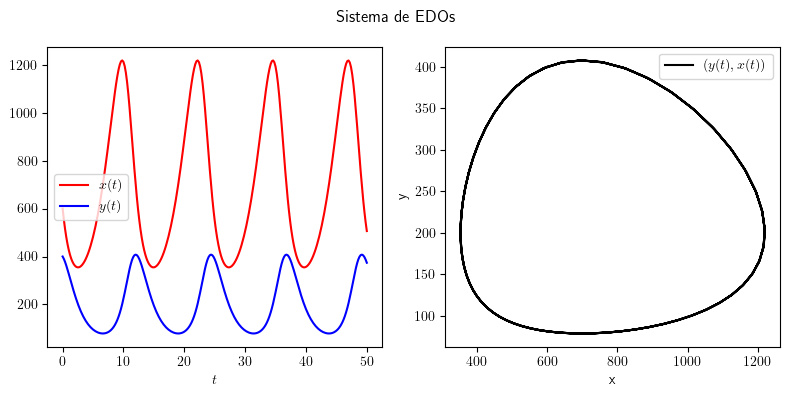

In [28]:
a, b, c, d = 0.4, 0.002, 0.001, 0.7
def f(xy, t):
    x, y = xy
    return (a * x - b * x * y,
            c * x * y - d * y)
xy0 = (600, 400) # condiciones iniciales
t_values, xy_values = resuelve_sistema(f, 0, 50, xy0, 250)
salida_sistema(t_values, xy_values, title="Sistema de EDOs")

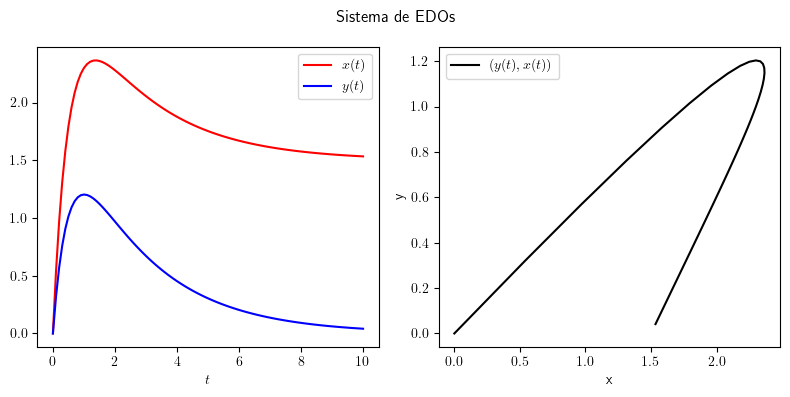

In [29]:
def f(x1x2, t):
    x1,x2 = x1x2
    return(
        -4*x1 + 3*x2 +6,
        -2.4*x1 + 1.6*x2 + 3.6
    )
xy0 = (0,0)
t_values, xy_values = resuelve_sistema(f, 0, 10, xy0, 100)
salida_sistema(t_values, xy_values, title="Sistema de EDOs")

## Ejercicio 9

> **Ejercicio 9 ✅:** Dado el siguiente PVI definido para $t\in[0,1]$:
> $$\left\{\begin{array}{rcl}
> x'(t) &=& \cos(x(t)) + t^2 \\
> x(0) &=& 1
> \end{array}\right.
> $$
> a) Intente encontrar la solución exacta del PVI.
>
> b) Aproxime numéricamente el PVI utilizando los métodos que considere y represente gráficamente las diferentes aproximaciones en el intervalo $[0,1]$.
>
> c) Para el método que observe que devuelve mejores resultados, estudie su sensibilidad a distintos valores de $N$ (por tanto de $h$).

En primer lugar, definimos la función simbólica correcpondiente, para intentar encontrar la solución exacta del PVI.

In [30]:
def f_sym(t,x):
    """
    Define simbólicamente la ecuación diferencial a resolver.
    
    Args:
        t (float): Valor de la variable independiente.
        x (float): Valor de la variable dependiente.
    Returns:
        float: Valor de la derivada de x respecto a t.
    """
    return sp.cos(x) + t**2

def f(t,x):
    """
    Define numéricamente la ecuación diferencial a resolver.
    
    Args:
        t (float): Valor de la variable independiente.
        x (float): Valor de la variable dependiente.
    Returns:
        float: Valor de la derivada de x respecto a t.
    """
    return np.cos(x) + t**2

x0 = 1
a = 0
b = 1

Si escomentamos la siguiente línea, vemos que nos da error y no es capaz de encontrar la solución exacta simbólicamente.

In [31]:
# Ver el error
# resolver_pvi_simbolico(f_sym, a, x0)

Antes de empezar a realizar la comparativa, representaremos la siguiente aproximación, cuyo código ha sido obtenido íntegramente del guión proporcionado en la práctica. Notemos que la aproximación obtenida por `integrate.odeint` no tiene por qué ser exacta.

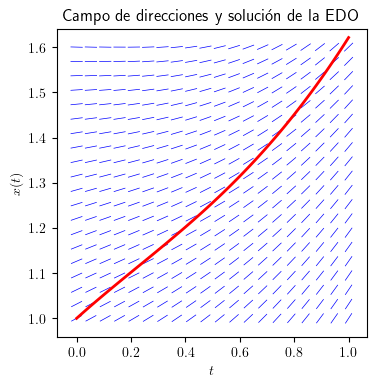

In [32]:
def plot_direction_field(f, t_lim=(-5, 5), x_lim=(-5, 5), ax=None):
    """
    Plots the direction field for the ODE dx/dt = f(t, x).
    Parameters:
    - f: function defining the ODE
    - t_lim: limits for the time axis
    - x_lim: limits for the dependent variable axis
    - ax: axis to plot on (if None, a new figure is created)
    """
        
    t_vec = np.linspace(t_lim[0], t_lim[1], 20)
    x_vec = np.linspace(x_lim[0], x_lim[1], 20)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))

    dt = t_vec[1] - t_vec[0]
    dx = x_vec[1] - x_vec[0]

    for m, tt in enumerate(t_vec):
        for n, xx in enumerate(x_vec):
            Dx = f(tt, xx) * dt
            Dt = 0.8 * dt**2 / np.sqrt(dt**2 + Dx**2)
            Dx = 0.8 * Dx*dx / np.sqrt(dt**2 + Dx**2)
            ax.plot([tt - Dt/2, tt + Dt/2],
                    [xx - Dx/2, xx + Dx/2], 'b', lw=0.5)
    ax.axis('tight')

def f_inv(x,t):
    return f(t, x)
t_values_pos = np.linspace(0, 1, 101)
x_values_pos = integrate.odeint(f_inv, x0, t_values_pos)


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_direction_field(f, ax=ax, t_lim=(0, 1), x_lim=(1, 1.6))
ax.plot(t_values_pos, x_values_pos, 'r', linewidth=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x(t)$")
ax.set_title(r"Campo de direcciones y solución de la EDO")
plt.show()


Imprimimos además los resultados obtenidos por `integrate.odeint` para comprobar que son correctos.

In [33]:
print("Valores de t y x para la EDO:")
print(f"N= {len(t_values_pos)-1}, x0= {x0}, a= {a}, b= {b}")
# Imprimimos los valores de t y x, con un salto de 10
for i in range(0, len(t_values_pos), 10):
    print(f"- t={t_values_pos[i]:.2f}, x={x_values_pos[i][0]:.15f}")

Valores de t y x para la EDO:
N= 100, x0= 1, a= 0, b= 1
- t=0.00, x=1.000000000000000
- t=0.10, x=1.052122043562585
- t=0.20, x=1.101839325799291
- t=0.30, x=1.151154965614887
- t=0.40, x=1.201914655919095
- t=0.50, x=1.255805941071721
- t=0.60, x=1.314362420539852
- t=0.70, x=1.378972118706380
- t=0.80, x=1.450890620511829
- t=0.90, x=1.531260196593157
- t=1.00, x=1.621136999025876


Buscamos por tanto una solución aproximada numéricamente. De los métodos no lineales explícitos, emplearemos el Runge-Kutta de 4 evaluaciones por ser muy empleado, y también el Runge-Kutta de 2 evaluaciones (aunque preveemos que será menos preciso).

No se pudo resolver el PVI simbólicamente.


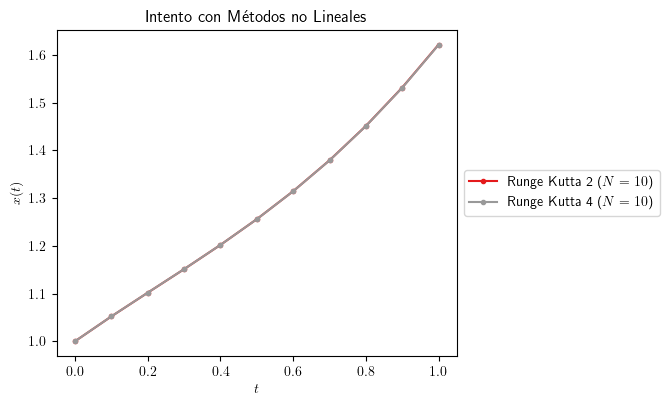

Aplicando Runge-Kutta 2 y 4 pasos:
N= 10, x0= 1, a= 0, b= 1
- t= 0.00, x_RK2=1.000000000000000, x_RK4=1.000000000000000
- t= 0.10, x_RK2=1.052064526633028, x_RK4=1.052122031583072
- t= 0.20, x_RK2=1.101758841267615, x_RK4=1.101839341423295
- t= 0.30, x_RK2=1.151082670017940, x_RK4=1.151155025980400
- t= 0.40, x_RK2=1.201877915174773, x_RK4=1.201914759548886
- t= 0.50, x_RK2=1.255828234292480, x_RK4=1.255806085593108
- t= 0.60, x_RK2=1.314463380603625, x_RK4=1.314362596135647
- t= 0.70, x_RK2=1.379167697518348, x_RK4=1.378972337433688
- t= 0.80, x_RK2=1.451193265433925, x_RK4=1.450890896435052
- t= 0.90, x_RK2=1.531679088497077, x_RK4=1.531260523539999
- t= 1.00, x_RK2=1.621678426840790, x_RK4=1.621137379169942


In [34]:
comparativa(f, a, b, x0, [runge_kutta_2_paso, runge_kutta_4_paso], Nmin=10, Nmax=10, razonN=2, title="Intento con Métodos no Lineales")

t_values_N, x_values_RK2 = metodo_un_paso(f, a, b, x0, 10, runge_kutta_2_paso)
t_values_N, x_values_RK4 = metodo_un_paso(f, a, b, x0, 10, runge_kutta_4_paso)

print("Aplicando Runge-Kutta 2 y 4 pasos:")
print(f"N= {len(t_values_N)-1}, x0= {x0}, a= {a}, b= {b}")
for i in range(0, len(t_values_N)):
    print(f"- t= {t_values_N[i]:.2f}, x_RK2={x_values_RK2[i]:.15f}, x_RK4={x_values_RK4[i]:.15f}")

Representamos ahora varias aproximaciones con métodos lineales, y siempre emplearemos los de Adams-Bashforth (por ser los de mayor orden explícitos programados) y Adams-Moulton (por ser los de mayor orden implícitos programados). Los implícitos siempre tendrán mayor precisión que los explícitos, pero tendrán un coste computacional mayor. Es por esto que también emplearemos el método MML Predictor-Corrector también programado.

En estos casos, los valores iniciales necesarios para los métodos de Adams-Bashforth los emplearemos con el método de Runge-Kutta de 4 evaluaciones.

No se pudo resolver el PVI simbólicamente.


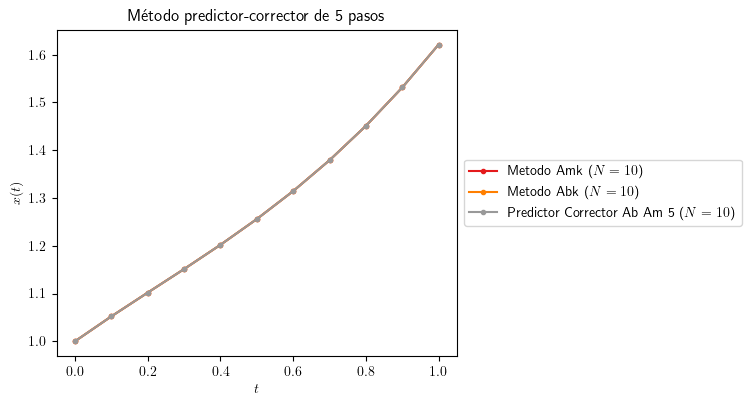

Aplicando Método de Adams-Bashforth, Adams-Moulton y Predictor-Corrector:
N= 10, x0= 1, a= 0, b= 1
- t= 0.00, x_AB=1.000000000000000, x_AM=1.000000000000000, x_PC=1.000000000000000
- t= 0.10, x_AB=1.052122031583072, x_AM=1.052122031583072, x_PC=1.052122031583072
- t= 0.20, x_AB=1.101839341423295, x_AM=1.101839341423295, x_PC=1.101839341423295
- t= 0.30, x_AB=1.151155025980400, x_AM=1.151155025980400, x_PC=1.151155025980400
- t= 0.40, x_AB=1.201914759548886, x_AM=1.201914759548886, x_PC=1.201914759548886
- t= 0.50, x_AB=1.255804124444443, x_AM=1.255805992810315, x_PC=1.255806160940857
- t= 0.60, x_AB=1.314359600069060, x_AM=1.314362425434219, x_PC=1.314362704121470
- t= 0.70, x_AB=1.378967881367062, x_AM=1.378972093469798, x_PC=1.378972474287977
- t= 0.80, x_AB=1.450885336349144, x_AM=1.450890583579047, x_PC=1.450891084275613
- t= 0.90, x_AB=1.531253056242644, x_AM=1.531260141897483, x_PC=1.531260803500357
- t= 1.00, x_AB=1.621127691490482, x_AM=1.621136928123531, x_PC=1.621137807064599

In [35]:
N = 10
h = (b - a)/N
k = 5
x = np.zeros(k)
x[0] = x0
for i in range(0, k-1):
    x[i+1] = runge_kutta_4_paso(f, a + i * h, x[i], h)

comparativa(f, 0, 1, x, [metodo_AMK_paso,metodo_ABK_paso,predictor_corrector_AB_AM_5], Nmin=10, Nmax=10, title=f"Método predictor-corrector de {k} pasos")


t_values_N, x_values_AB = metodo_k_pasos(f, 0, 1, x, 10, metodo_ABK_paso)
t_values_N, x_values_AM = metodo_k_pasos(f, 0, 1, x, 10, metodo_AMK_paso)
t_values_N, x_values_PC = metodo_k_pasos(f, 0, 1, x, 10, predictor_corrector_AB_AM_5)
print("Aplicando Método de Adams-Bashforth, Adams-Moulton y Predictor-Corrector:")
print(f"N= {len(t_values_N)-1}, x0= {x0}, a= {a}, b= {b}")
for i in range(0, len(t_values_N)):
    print(f"- t= {t_values_N[i]:.2f}, x_AB={x_values_AB[i]:.15f}, x_AM={x_values_AM[i]:.15f}, x_PC={x_values_PC[i]:.15f}")

Como vemos, todos proporcionan buenos resultados. De los métodos lineales, cabe esperar que el más preciso sea el de Adams-Moulton, puesto que es el implícito (como ya hemos comentado). El método MML Predictor-Corrector, siendo explícito, también proporciona buenos resultados. No obstante, optaremos el método de Runge-Kutta de 4 evaluaciones por varios motivos. En primer lugar, su orden de prcisión es alto, y aunque no sea lineal, es un método explícito y de bajo coste computacional. Además, es un método muy empleado en la práctica. Por tanto, lo emplearemos para realizar la comparativa de sensibilidad a distintos valores de $N$.

No se pudo resolver el PVI simbólicamente.


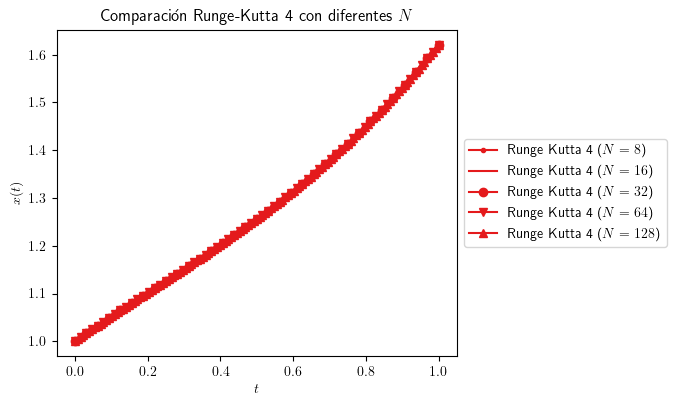

Aplicando Runge-Kutta 4 pasos con diferentes N:
- t= 0.00, (N=8)=1.000000000000000, (N=16)=1.000000000000000, (N=32)=1.000000000000000, (N=128)=1.000000000000000
- t= 0.12, (N=8)=1.064695919732612, (N=16)=1.064695897522305, (N=32)=1.064695895454064, (N=128)=1.064695895295122
- t= 0.25, (N=8)=1.126428371904727, (N=16)=1.126428265448717, (N=32)=1.126428257746760, (N=128)=1.126428257202499
- t= 0.38, (N=8)=1.188994627232447, (N=16)=1.188994390744102, (N=32)=1.188994374786606, (N=128)=1.188994373690893
- t= 0.50, (N=8)=1.255806336784984, (N=16)=1.255805933989028, (N=32)=1.255805907685455, (N=128)=1.255805905905313
- t= 0.62, (N=8)=1.329896729896457, (N=16)=1.329896129396232, (N=32)=1.329896090901717, (N=128)=1.329896088318496
- t= 0.75, (N=8)=1.413944760636186, (N=16)=1.413943933380117, (N=32)=1.413943880932280, (N=128)=1.413943877430641
- t= 0.88, (N=8)=1.510317592570918, (N=16)=1.510316511436091, (N=32)=1.510316443313063, (N=128)=1.510316438777650
- t= 1.00, (N=8)=1.621138233474170, (N=1

In [39]:
comparativa(f, a, b, x0, [runge_kutta_4_paso], Nmin=8, Nmax=128, razonN=2, title="Comparación Runge-Kutta 4 con diferentes $N$")

N_values = [8, 16, 32,128]
t_values_N = [None] * len(N_values)
x_values_RK4 = [None] * len(N_values)

for i,N in enumerate(N_values):
    t_values_N[i], x_values_RK4[i] = metodo_un_paso(f, a, b, x0, N, runge_kutta_4_paso)

print("Aplicando Runge-Kutta 4 pasos con diferentes N:")
for i,t in enumerate(t_values_N[0]):
    print(f"- t= {t:.2f}", end="")
    for j in range(len(N_values)):
        prop = round(N_values[j] / N_values[0])
        print(f", (N={N_values[j]})={x_values_RK4[j][i*prop]:.15f}", end="")
    print()

Como vemos, para distintos valores de $N$, el método de Runge-Kutta de 4 evaluaciones proporciona resultados similares. Aunque la precisión aumenta con el número de pasos, el coste computacional también aumenta. En este caso, las primeras 5 cifras decimales de la última aproximación son idénticas. por lo que podríamos deducir (depende del caso) que no ha merecido la pena aumentar el número de pasos. No obstante, en otros casos, sí que podría ser necesario aumentar el número de pasos para obtener una precisión mayor.